# **Pattern Recognition Course (Fall 2024)**

# **Assignment 1: Bayesian classifier**

Due date: 3th Aban 1403

---

Tasks:

1.  Tri-area segmentation

    - class 1: sky
    - grass
    - elephant

2.  Dual-area segmentation
    - background
    - elephant


In [2]:
import cv2
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import random
import math
from dataclasses import dataclass
from typing import Tuple, Optional

%matplotlib inline

# Auxiliary Structures and Functions


In [3]:
def read_samples(sample_paths: list):
    samples_arr = np.empty(len(sample_paths), dtype=object)

    for i, p_path in enumerate(sample_paths):
        pic_bgr = cv2.imread(p_path)

        if pic_bgr is not None:
            pic_rgb = cv2.cvtColor(pic_bgr, cv2.COLOR_BGR2RGB)
            pic_rgb_pixels = pic_rgb.reshape(-1, 3)
            samples_arr[i] = pic_rgb_pixels

    return samples_arr


def stack_all_samples(samples_arr):
    n = len(samples_arr)
    stacked_pixels = np.concatenate([samples_arr[i] for i in range(n)], axis=0)

    return stacked_pixels


@dataclass
class Segment:
    name: str
    grayscale_val: int
    samples: NDArray
    prior: Optional[float] = None
    mean: Optional[NDArray] = None
    cov: Optional[NDArray] = None

    def est_params(self) -> Tuple[NDArray, NDArray]:
        self.mean = np.mean(self.samples, axis=0)
        diff = self.samples - self.mean
        self.cov = np.cov(diff, rowvar=False)

# Stage 1 : Data Acquisition


1. Use ‘elephant_walking.bmp’ as an input imageand show it.


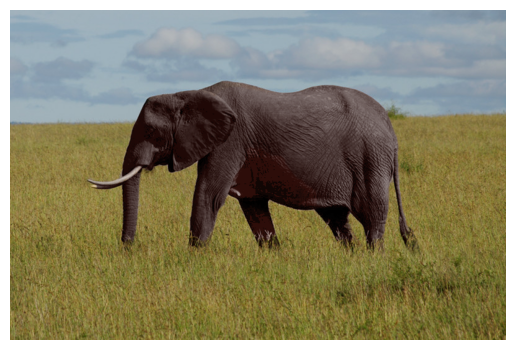

In [4]:
main_bgr = cv2.imread("elephant_walking.bmp")
main_rgb = cv2.cvtColor(main_bgr, cv2.COLOR_BGR2RGB)

plt.axis("off")
plt.imshow(main_rgb);

2. Use `‘s1.bmp’`, `‘s2.bmp’` and `‘s3.bmp’` to identify sample pixels for class 1
   `sky`


In [5]:
sky_sample_paths = ["s1.bmp", "s2.bmp", "s3.bmp"]
sky_sample_arr = read_samples(sky_sample_paths)
sky_sample_pixels = stack_all_samples(sky_sample_arr)
sky = Segment(name="sky", grayscale_val=255, samples=sky_sample_pixels)

print(f"Total number of samples collected as pixels = {sky.samples.shape[0]}")

Total number of samples collected as pixels = 7600


3. Use ‘g1.bmp’, ‘g2.bmp’ and ‘g3.bmp’ to identify sample pixels for class 2 (grass). w2 = grass


In [6]:
grass_sample_paths = ["g1.bmp", "g2.bmp", "g3.bmp"]
grass_sample_arr = read_samples(grass_sample_paths)
grass_sample_pixels = stack_all_samples(grass_sample_arr)
grass = Segment(name="grass", grayscale_val=125, samples=grass_sample_pixels)

print(f"Total number of samples collected as pixels = {grass.samples.shape[0]}")


Total number of samples collected as pixels = 7800


4. Use `‘e1.bmp’`, `‘e2.bmp’` and `‘e3.bmp’` to identify sample pixels for class 3 (elephant).

> _Hint: Delete white pixels and don’t use these pixels as sample pixels for class 3 w3 = elephant_


In [7]:
el_sample_paths = ["e1.bmp", "e2.bmp", "e3.bmp"]
el_sample_arr = read_samples(el_sample_paths)
el_sample_pixels_unmasked = stack_all_samples(el_sample_arr)
el = Segment(name="elephant", grayscale_val=0, samples=el_sample_pixels_unmasked)

print(
    f"Total number of samples collected as pixels (before masking) = {el.samples.shape[0]}"
)

Total number of samples collected as pixels (before masking) = 634250


# Stage 2: Data cleaning and Preprocessing


In [8]:
el_sample_pixels = np.delete(
    el_sample_pixels_unmasked, np.where(el_sample_pixels_unmasked == 255), axis=0
)
el.samples = el_sample_pixels

print(
    f"Total number of samples collected as pixels (after masking) = {el.samples.shape[0]}"
)

Total number of samples collected as pixels (after masking) = 269434


# Stage 3 : Feature Selection


5. Plot in a 3D space (Red-Green-Blue) preceding pixels.

   Do the classes seem separable for these characteristics i.e R, G and B ?


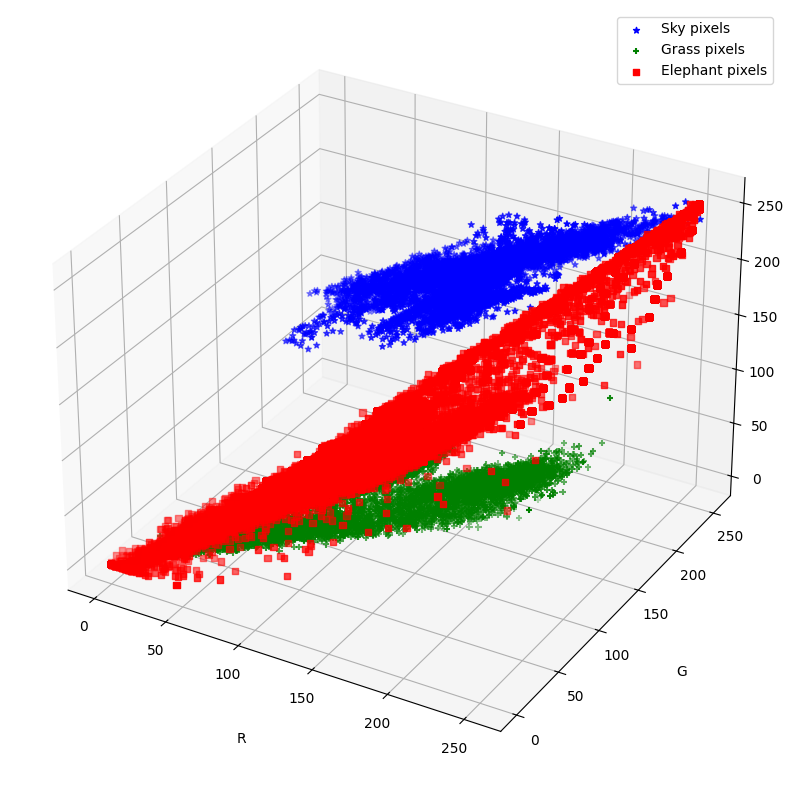

In [9]:
fig_2 = plt.figure(figsize=(8, 8))
ax_2 = fig_2.add_subplot(111, projection="3d")

ax_2.scatter(
    sky.samples[:, 0],
    sky.samples[:, 1],
    sky.samples[:, 2],
    c="b",
    marker="*",
    label="Sky pixels",
)
ax_2.scatter(
    grass.samples[:, 0],
    grass.samples[:, 1],
    grass.samples[:, 2],
    c="g",
    marker="+",
    label="Grass pixels",
)
ax_2.scatter(
    el_sample_pixels[:, 0],
    el_sample_pixels[:, 1],
    el_sample_pixels[:, 2],
    c="r",
    marker="s",
    label="Elephant pixels",
)

ax_2.set_xlabel("R", labelpad=20)
ax_2.set_ylabel("G", labelpad=20)
ax_2.set_zlabel("B", labelpad=20)
plt.subplots_adjust(left=0.1, right=0.8, top=0.8, bottom=0.2)
# ax.set_box_aspect([2, 2, 2])  # Aspect ratio is 1:1:1

ax_2.legend()
plt.tight_layout()
plt.show();

# Stage 4: Model Training


6. Estimate parameters of probabilities 𝑝(𝑥|𝑤𝑖 ) for a **Gaussian model** starting from these samples.

---

the probability density function following mathvariant normal distribution is:

$
f(\mathbf{x}) = \frac{1}{(2\pi)^{k/2} |\Sigma|^{1/2}} \exp\left( -\frac{1}{2} (\mathbf{x} - \boldsymbol{\mu})^\top \Sigma^{-1} (\mathbf{x} - \boldsymbol{\mu}) \right)
$
<br/>
<br/>


In [10]:
sky.est_params()
grass.est_params()
el.est_params()

print(f"sky mean\n\t{sky.mean}\nsky cov\n\t{sky.cov}")
print("\n")
print(f"grass mean\n\t{grass.mean}\ngrass cov\n\t{grass.cov}")
print("\n")
print(f"elephant mean\n\t{el.mean}\nelephant cov\n\t{el.cov}")

sky mean
	[147.32605263 176.57157895 198.69894737]
sky cov
	[[831.30307166 622.84572014 308.56612823]
 [622.84572014 524.4907305  304.46832118]
 [308.56612823 304.46832118 251.56931064]]


grass mean
	[126.54448718 107.85448718  35.10615385]
grass cov
	[[1987.02840915 1563.37030298  504.20453451]
 [1563.37030298 1335.34579343  482.50538333]
 [ 504.20453451  482.50538333  290.46263683]]


elephant mean
	[83.29256144 68.66183926 62.86008447]
elephant cov
	[[2527.66712523 2561.69668102 2524.52446056]
 [2561.69668102 2631.63123856 2608.24522244]
 [2524.52446056 2608.24522244 2606.81939282]]


7. Use ‘gt1.bmp’ as a ground-truth image.


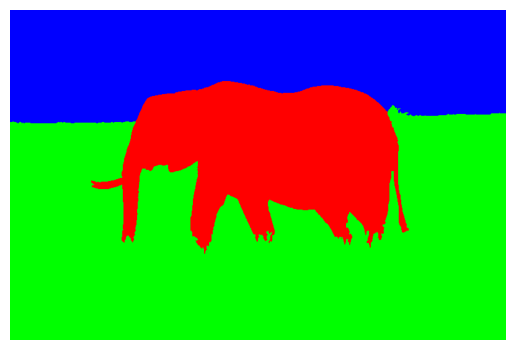

In [11]:
gt_bgr = cv2.imread("gt1.bmp")
gt_rgb = cv2.cvtColor(gt_bgr, cv2.COLOR_BGR2RGB)

plt.axis("off")
plt.imshow(gt_rgb);

8. Estimate the prior probabilities 𝑝(𝑤𝑖 ) in the following way:

- Generate by chance the coordinates of (x, y) of 1000 pixels of the image
- Count the number of pixels belonging to each class by using ground-truth image and divide by 1000.


In [12]:
h_gt, w_gt, _ = gt_rgb.shape
n_points = 1000

x_list = [random.randint(0, w_gt - 1) for _ in range(n_points)]
y_list = [random.randint(0, h_gt - 1) for _ in range(n_points)]

r_count = 0
g_count = 0
b_count = 0

r_vect = np.array([255, 0, 0])
g_vect = np.array([0, 255, 0])
b_vect = np.array([0, 0, 255])

for y, x in zip(y_list, x_list):
    if all(gt_rgb[y, x, :] == r_vect):
        r_count += 1
    elif all(gt_rgb[y, x, :] == g_vect):
        g_count += 1
    else:
        b_count += 1

sky.prior = b_count / n_points
grass.prior = g_count / n_points
el.prior = r_count / n_points


print(f"P(El)= {el.prior} \nP(Grass) = {grass.prior} \nP(Sky) = {sky.prior}")
print(f"P(S) = {el.prior + sky.prior + grass.prior}")


P(El)= 0.215 
P(Grass) = 0.496 
P(Sky) = 0.289
P(S) = 1.0


9. Use a Bayesian classifier to automatically segment the image in 3 areas (black, gray and white) corresponding to the classes.

$
\begin{align}
\mathbf{g}_i(\boldsymbol x) = & -\frac{d}{2} \ln(2\pi) \\
& - \frac{1}{2} \ln(|\boldsymbol{\Sigma}|) \\
& - \frac{1}{2} (\mathbf{x} - \boldsymbol{\mu})^T \boldsymbol{\Sigma}^{-1} (\mathbf{x} - \boldsymbol{\mu})\\
& + lnP(w)
\end{align}
$


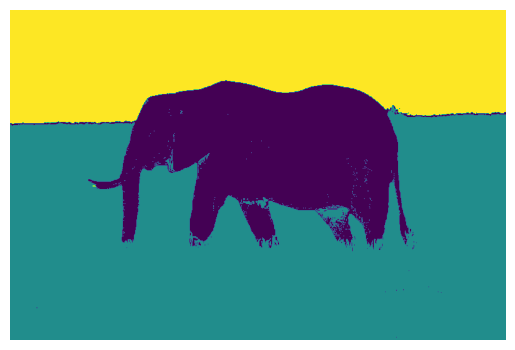

In [13]:
def discriminant_f(  # noqa: F811
    data_point: NDArray,
    segment: Segment,
) -> float:  # noqa:
    segment.mean.shape[0]
    d = segment.mean.shape[0]
    inv_cov = np.linalg.inv(segment.cov)
    det_cov = np.linalg.det(segment.cov)
    diff = data_point - segment.mean

    term_1 = (d / 2) * math.log(2 * np.pi, math.e)
    term_2 = 0.5 * math.log(det_cov, math.e)
    term_3 = 0.5 * np.dot(diff.T, np.dot(inv_cov, diff))
    term_4 = math.log(segment.prior, math.e)

    g_x = -(term_1 + term_2 + term_3) + term_4

    return g_x


h, w, _ = main_rgb.shape
grayscale_result = np.zeros((h, w), dtype=np.uint8)

for y in range(h):
    for x in range(w):
        p = main_rgb[y, x, :]

        sky_chance = discriminant_f(data_point=p, segment=sky)
        grass_chance = discriminant_f(data_point=p, segment=grass)
        el_chance = discriminant_f(data_point=p, segment=el)

        chance_to_grayscale = {
            el_chance: el.grayscale_val,
            grass_chance: grass.grayscale_val,
            sky_chance: sky.grayscale_val,
        }

        winner = chance_to_grayscale.get(max(chance_to_grayscale.keys()))
        grayscale_result[y, x] = winner


plt.imshow(grayscale_result)
plt.axis("off")  # Hide axes
plt.show()


# Stage 5: Evaluation


10. What is the total error of classification for all pixels in the image? Using ground-truth image to check whether pixels are well classified or not.


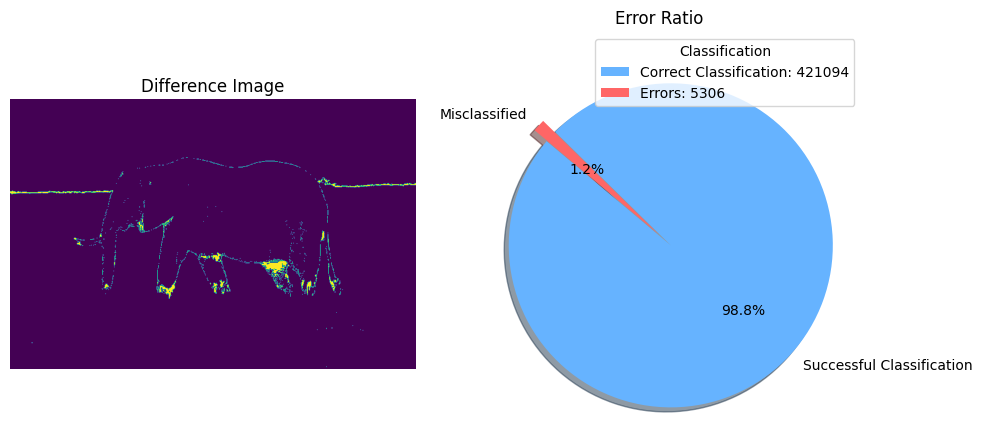

In [20]:
rgb_to_grayscale = {
    tuple(r_vect): el.grayscale_val,
    tuple(g_vect): grass.grayscale_val,
    tuple(b_vect): sky.grayscale_val,
}
error_count = 0
diff_result = np.zeros(shape=grayscale_result.shape, dtype=np.uint8)

for y in range(h_gt):
    for x in range(w_gt):
        gt_val = gt_rgb[y, x, :]
        if rgb_to_grayscale.get(tuple(gt_val)) != grayscale_result[y, x]:
            error_count += 1
            diff_result[y, x] = 255


correct_count = h_gt * w_gt - error_count
success = (correct_count / (h_gt * w_gt)) * 100
failure = (error_count / (h_gt * w_gt)) * 100

fig_result, axs_result = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

axs_result[0].imshow(diff_result)
axs_result[0].set_title("Difference Image")
axs_result[0].axis("off")

labels = ["Successful Classification", "Misclassified"]
sizes = [success, failure]
colors = ["#66b3ff", "#ff6666"]
explode = (0.1, 0)

axs_result[1].pie(
    sizes,
    explode=explode,
    labels=labels,
    colors=colors,
    autopct="%1.1f%%",
    shadow=True,
    startangle=140,
)
axs_result[1].set_title("Error Ratio")
axs_result[1].legend(
    [f"Correct Classification: {correct_count}", f"Errors: {error_count}"],
    title="Classification",
    loc="upper right",
)

plt.tight_layout()
plt.show()